In [ ]:
for name in ["KICH","KIRP","STAD"]:
    for i in range(1,11):
        fname = name +"_"+str(i)
        a = np.loadtxt("./Dataset/GeneNetwork/Pair-SSN/"+fname+".txt",dtype=str,delimiter=",")
        np.savetxt("./Dataset/GeneNetwork/Pair-SSN/"+fname+".txt",a,fmt='%s')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import copy
import networkx as nx
import torch
#from open_spiel.python.algorithms import random_agent
from igraph import Graph
from sklearn.metrics import f1_score
import sys
sys.path.append("../")
from utils.reinforcement_learning.dqn_TS import DQN
from utils.params import Params
from utils.evaluation.evaluationhelper import EvaluateModel,EvaluateACTION
from utils.environment.nodeCentrality import Node_Centrality
from utils.environment.globalFeature import Global_Feature
from utils.validation import get_Validation, area_under_curve
from utils.environment.game import GraphGame
from utils.environment.envhelper import reset
from utils.reinforcement_learning.rl_environment import Environment
from utils.getClass import objective_function,get_class_from_file
        
    
def find_critical_point(value):
    """
    Find the critical point of the percolation curve using the second derivative.
    """
    x = np.linspace(0.0, 1.0, num=len(value))
    #d2pc = np.gradient(np.gradient(value, x), x[1]-x[0])
    gradient = np.gradient(np.gradient(value))
    #pc_max = p_vals[np.argmax(d2pc)]
    ps = np.abs(np.fft.fft(gradient))
    ps[0:10] = 1
    return np.argmin(ps), ps

def get_action(GRAPH,action,value,name,indexOn=True):
    name = name.split("_")[0]
    geneName = np.loadtxt("./Dataset/GeneNetwork/Gene_Feature/"+name+"_Gene_List.txt",dtype=str)
    NCG_Cancer = np.loadtxt("./Dataset/GeneNetwork/Gene_Feature/NCG_name.txt",dtype=str)
    CGC_Cancer = np.loadtxt("./Dataset/GeneNetwork/Gene_Feature/CGC_name.txt",dtype=str)
    count = 0 
    true_label = np.zeros(GRAPH.vcount())
    predicted_label = np.zeros(GRAPH.vcount())
    transition = int(0.25 * GRAPH.vcount())#find_critical_point(value)
    #transition, gradient = find_critical_point(value)
    for i, personalizes_gene in enumerate(GRAPH.vs["name"]):
        gene = geneName[int(personalizes_gene)-1] 
        true_label[i] =  1 if (gene in NCG_Cancer) or (gene in CGC_Cancer) else 0
    if indexOn:
        for j, potential_gene in enumerate(action):
            cancer_index = GRAPH.vs[potential_gene]["name"]
            gene = geneName[int(cancer_index)-1] 
            predicted_label[j] =  1 if (gene in NCG_Cancer) or (gene in CGC_Cancer) else 0
            if j == transition:
                break
    else:
        for j, potential_gene in enumerate(action):
            cancer_index = potential_gene
            gene = geneName[int(cancer_index)-1] 
            predicted_label[j] =  1 if (gene in NCG_Cancer) or (gene in CGC_Cancer) else 0
            if j == transition:
                break
    fscore = f1_score(true_label, predicted_label)
    return fscore, sum(predicted_label), sum(true_label)
    
    
def input_graph(graph_path,file):
    GRAPH = Graph.Read_Ncol(graph_path+str(file)+".txt", directed=False)
    nodes = [v.index for v in GRAPH.vs]
    map = {n:int(i) for i, n in enumerate(nodes)}
    GRAPH = reset(GRAPH)  
    Graph.simplify(GRAPH)
    return GRAPH, map

def implement_GNN(model_iteration,parameter_path,GRAPH,useSingleStep= None):
    params = Params(parameter_path)
    objectiveFunction = objective_function("utils/environment/objectiveFunction.py",params.objective_function)
    if objectiveFunction.__name__ == "numberConnectedComponent":
        condMaxNum = True
    else:
        condMaxNum = False
    model = torch.load(params.checkpoint_dir+'_'+str(model_iteration))
    game = GraphGame
    env = Environment(game)
    nodeCentrality = Node_Centrality(params.centrality_feature_name)
    globalFeature = Global_Feature(params.global_feature_name)
    attacker = DQN(state_representation_size=params.centrality_features,
                    hidden_layers_sizes= params.hidden_layers,
                   global_feature_size =params.global_features)
    attacker._q_network.load_state_dict(model["_q_network"])
    attacker._optimizer.load_state_dict(model["_optimizer"])
    rewards, lcc, actions = EvaluateModel(env,objectiveFunction,nodeCentrality,globalFeature, attacker,GRAPH,useSingleStep)
    if condMaxNum:
        l = np.array(lcc)
        lcc = (l[-1] - l + 1)/l[-1]
    else:
        lcc = np.array(lcc)/lcc[0]
    return rewards, lcc, actions
    
def implement_Bench(fname,GRAPH,objectiveFunction,indexOn = False):
    if objectiveFunction.__name__ == "numberConnectedComponent":
        condMaxNum = True
    else:
        condMaxNum = False
    action_list = np.loadtxt(fname, dtype=int)
    _, lcc, actions = EvaluateACTION(action_list,objectiveFunction,GRAPH,indexOn)
    if condMaxNum:
        l = np.array(lcc)
        lcc = (l[-1] - l + 1)/l[-1]
    else:
        lcc = np.array(lcc)/lcc[0]
    return lcc, actions
    #GRAPH.vertex["name"],


def visual_evaluation(graph_path,file_list,list_parameter,best_model,name,title,plot_grid,grid,action_list,save = False): 
    #figure, axis = plt.subplots(grid[0],grid[1],sharex=True,figsize=(18, 6))
    figure, axis = plt.subplots(grid[0],grid[1],figsize=(24, 6), dpi=100, constrained_layout=True)
    for i, graph_name in enumerate(file_list):
        print(graph_name, end='=> ')
        GRAPH, map = input_graph(graph_path,graph_name)
        N = GRAPH.vcount()
        action={}
        print(N)
        for model, attacker in enumerate(list_parameter):
            rewards, result, actions = implement_GNN(best_model[model],attacker, GRAPH.copy(),useSingleStep=None)
            if name[model] == "MinMax":
                color_model = "#377eb8"
                condMaxNum = False
            elif name[model] == "CNP":
                color_model = "#4daf4a" 
                condMaxNum = False
            else:
                color_model = "#e41a1c"
                condMaxNum = True
                l = np.array(result)
                result = (l[-1] - l + 1)/l[-1]
            x =  np.flip(np.arange(N+1)[N:0:-1]/N)
            axis[plot_grid[i]].plot(x[:len(result)],np.array(result)/result[0], color = color_model,label=name[model])
            f1, count, totalGene = get_action(GRAPH,actions,graph_name)
            print(name[model],"=>",f1,count,totalGene, len(actions),N)
            action[name[model]] = {
                    "nodes":N,
                    "count": count,
                    "f1": f1,
                    "totalGene": totalGene,
                    "actions":actions}
        axis[plot_grid[i]].set_title(graph_name, fontdict={'fontsize': 18})
        if i == 0 :
            axis[plot_grid[i]].legend(loc="upper right") 
        action_list[graph_name] = action
    figure.supxlabel("Fraction of Nodes Removed", fontsize=18)
    figure.supylabel("ObjectiveFunction", fontsize=18)
    if save:
        plt.savefig("./Figure/Compiled/HDA/Gene/Gene_"+title+".pdf")
    plt.show()
    return action_list

In [ ]:
import json
import sys
import json
from utils.evaluation.jsonEncoder import NpEncoder
def get_from_json(file_path):
    with open(file_path) as json_file:
        data = json.load(json_file)
    return data


# Compare for each Objective Function

In [ ]:
'''MIX_MinMax = 85000  
MIX_CNP = 98500
MIX_MaxNum = 284000 
parameter = ["./hyperparameters/Mix/mixed_params_All.json",
             "./hyperparameters/Mix/mixed_params_CN.json",
             "./hyperparameters/Mix/mixed_params_MaxNum.json"
            ]
name = ["MinMax","CNP","MaxNum"]
best_model= [MIX_MinMax,MIX_CNP,MIX_MaxNum]
file_list = ["STAD_1","STAD_2","STAD_3","STAD_4","STAD_5","STAD_6","STAD_7","STAD_8","STAD_9","STAD_10"]
graph_path =  "./Dataset/GeneNetwork/Pair-SSN/"
x, y = 1, 5
grid_plot = [j for j in range(y)]
JSON_FILE = get_from_json("./Figure/Compiled/HDA/Gene/personalized_gene.json")
JSON_FILE =visual_evaluation(graph_path,file_list,parameter,best_model,name,"STAD",grid_plot,[x,y],JSON_FILE,save=True)
with open("./Figure/Compiled/HDA/Gene/personalized_gene.json", "w") as outfile:
    json.dump(JSON_FILE, outfile, cls=NpEncoder)'''

## GET GENE for all the selected action

In [ ]:
JSON_FILE = get_from_json("./Figure/Compiled/HDA/Gene/personalized_gene.json")
def get_Gene(NAME,action):
    graph_path = "./Dataset/GeneNetwork/"
    GRAPH, map = input_graph(graph_path,NAME)
    name = NAME.split("_")[0]
    geneName = np.loadtxt("./Dataset/GeneNetwork/Gene_Feature/"+name+"_Gene_List.txt",dtype=str)
    count = 0 
    predicted_gene = []
    for j, potential_gene in enumerate(action):
        cancer_index = GRAPH.vs[potential_gene]["name"]
        gene = geneName[int(cancer_index)-1] 
        predicted_gene.append(gene)
    return predicted_gene
    
def get_gene_dataset(result):
    for dataset in result:
        for model in result[dataset]:
            list_actions = result[dataset][model]["actions"]
            predicted_gene = get_Gene(dataset,list_actions)
            result[dataset][model]["gene"] = predicted_gene
    return result

JSON_FILE = get_gene_dataset(result)
with open("./Figure/Compiled/HDA/Gene/personalized_gene.json", "w") as outfile:
    json.dump(JSON_FILE, outfile, cls=NpEncoder)

In [16]:
with open("./Figure/Compiled/HDA/Gene/personalized_gene.json", "r") as infile:
    result = json.load(infile)

In [ ]:
import collections
NCG_Cancer = np.loadtxt("./Dataset/GeneNetwork/Gene_Feature/NCG_name.txt",dtype=str)
CGC_Cancer = np.loadtxt("./Dataset/GeneNetwork/Gene_Feature/CGC_name.txt",dtype=str)
def get_frequency(result,CANCER, obj, model):
    all_gene = []
    a =  1
    for i, dataset in enumerate(result):
        if dataset.split("_")[0] == CANCER:
            a += 1
            all_gene += result[dataset][obj][model]["gene"]
    gene_count = collections.Counter(all_gene)
    # printing the element and the frequency  
    sorted_gene_count = sorted(gene_count.items(), key=lambda x:x[1], reverse=True)
    sorted_gene_count = [[gene,count/(a)] for (gene, count) in sorted_gene_count]
    return np.array(sorted_gene_count)
def get_frequency_range(gene_count):
    frequency = np.array(gene_count[:,1],dtype= float)
    fh = frequency[frequency > 0.6]
    fm = frequency[frequency > 0.3]
    fm  = fm[(fm < 0.6)]
    fl = frequency[(frequency < 0.3)]
    return fl, fm, fh
def plot_barh(result,obj,model):
    cancer_list = np.unique([k.split("_")[0] for k in result.keys()])
    data = {"fl":[],"fm":[],"fh":[]}
    for cancer in cancer_list:
        sorted_frequency = get_frequency(result,cancer,obj,model)
        fl, fm, fh =  get_frequency_range(sorted_frequency)
        data["fl"].append(len(fl)/len(sorted_frequency))
        data["fm"].append(len(fm)/len(sorted_frequency))
        data["fh"].append(len(fh)/len(sorted_frequency))
    b1 = plt.barh(cancer_list, data["fl"], color="#ffeda0")
    b2 = plt.barh(cancer_list, data["fm"], left=data["fl"], color="#feb24c")
    b3 = plt.barh(cancer_list, data["fh"], left=np.add(data["fl"], data["fm"]), color="#f03b20")
    plt.legend([b1, b2, b3], ["fl", "fm", "fh"], title="Frequency", bbox_to_anchor=(1, 1.05))
    plt.title(obj+": Frequency distribution of found genes")
    plt.show()
result = get_from_json("./Figure/Compiled/HDA/Gene/personalized_gene.json")
plot_barh(result,"MinMax","our")
#plot_barh(result,"CNP")
#plot_barh(result,"MaxNum")

In [ ]:
import math
import matplotlib
from scipy.stats import hypergeom
font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)
model_list = ["MinMax", "CNP", "MaxNum"]
def compute_F1(result,model_list):
        pValue = {}
        for model in model_list:
            pValue[model] = []
            for cancer_patient in (result.keys()):
                cancer = cancer_patient.split("_")[0] 
                fmeasure = result[cancer_patient][model]["f1"]
                pValue[model].append(fmeasure)
        fig, ax =plt.subplots(figsize =(12,8), dpi=100)
        ax.boxplot(pValue.values())
        ax.set_xticklabels(model_list)
        ax.set_title("The enrichment F-scores of models in the list of CCG and NCG genes", fontsize=14,fontweight="bold")
        plt.ylabel("Fmeasure for each personalized network", fontsize=18)
        plt.show()
compute_F1(result,model_list)

In [ ]:
JSON_FILE = get_from_json("./Figure/Compiled/HDA/Gene/personalized_gene.json")
def get_SOAT(result,objFunc,graph_path,grid,plot_grid,file_list,title):
    figure, axis = plt.subplots(grid[0],grid[1],figsize=(24, 6), dpi=100, constrained_layout=True)
    for i, graph_name in enumerate(file_list):
        GRAPH, map = input_graph(graph_path,graph_name)
        N = GRAPH.vcount()
        #result[res][objFunc]["model"]:
        x =  np.flip(np.arange(N+1)[N:0:-1]/N)
        if objFunc == "MinMax":
            model = {}
            objectiveFunction = objective_function("utils/environment/objectiveFunction.py","largestConnectedComponent")
            attacker = f"./hyperparameters/BA/{objFunc}/ba_params_Best_New.json"
            BA_MinMax = 66500
            _, lcc_ba, action_ba = implement_GNN(BA_MinMax,attacker, GRAPH.copy(),useSingleStep=None)
            f1, count, totalGene = get_action(GRAPH,action_ba,lcc_ba,graph_name,indexOn=True)
            model["ba"] = {
                    "nodes":N,
                    "count": count,
                    "f1": f1,
                    "totalGene": totalGene,
                    "actions":action_ba,
                    "obj":lcc_ba
            }
            attacker = f"./hyperparameters/Mix/{objFunc}/mixed_params_All.json"
            MIX_MinMax = 85000  
            _, lcc_our, action_our = implement_GNN(MIX_MinMax,attacker, GRAPH.copy(),useSingleStep=None)
            f1, count, totalGene = get_action(GRAPH,action_our,lcc_our,graph_name,indexOn=True)
            model["mix"] = {
                    "nodes":N,
                    "count": count,
                    "f1": f1,
                    "totalGene": totalGene,
                    "actions":action_our,
                    "obj":lcc_our
            }
            fname = "./CI/L_2/"+graph_name+".txt"
            lcc_ci, action_ci = implement_Bench(fname,GRAPH.copy(),objectiveFunction,indexOn = False)
            f1, count, totalGene = get_action(GRAPH,action_ci,lcc_ci,graph_name,indexOn=False)
            model["ci"] = {
                    "nodes":N,
                    "count": count,
                    "f1": f1,
                    "totalGene": totalGene,
                    "actions":action_ci,
                    "obj":lcc_ci
            }
            fname = "./FINDER/FINDER_ReTrained/"+graph_name+".txt"
            lcc_finder, action_finder = implement_Bench(fname,GRAPH.copy(),objectiveFunction,indexOn = True)
            f1, count, totalGene = get_action(GRAPH,action_finder,lcc_finder,graph_name,indexOn=True)
            model["finder"] = {
                    "nodes":N,
                    "count": count,
                    "f1": f1,
                    "totalGene": totalGene,
                    "actions":action_finder,
                    "obj":lcc_finder
            }
            fname = "./GDM/GDM_MinMax/"+graph_name+".txt"
            lcc_gdm, action_gdm = implement_Bench(fname,GRAPH.copy(),objectiveFunction,indexOn = True)
            f1, count, totalGene = get_action(GRAPH,action_gdm,lcc_gdm,graph_name)
            model["gdm"] = {
                    "nodes":N,
                    "count": count,
                    "f1": f1,
                    "totalGene": totalGene,
                    "actions":action_gdm,
                    "obj":lcc_gdm
            }
            fname = "./CoreHD/COREHD_New/"+graph_name+".txt"
            lcc_core, action_core = implement_Bench(fname,GRAPH.copy(),objectiveFunction,indexOn=False)
            f1, count, totalGene = get_action(GRAPH,action_core,lcc_core,graph_name,indexOn=False)
            model["core"] = {
                    "nodes":N,
                    "count": count,
                    "f1": f1,
                    "totalGene": totalGene,
                    "actions":action_core,
                    "obj":lcc_core
            }    

        elif objFunc == "CNP":
            model = {}
            objectiveFunction = objective_function("utils/environment/objectiveFunction.py","pairwiseConnectivity")
            objectiveFunction = objective_function("utils/environment/objectiveFunction.py","largestConnectedComponent")
            attacker = "./hyperparameters/BA/ba_params_CN_New.json"
            BA_CNP = 52000
            _, lcc_ba, action_ba = implement_GNN(BA_CNP,attacker, GRAPH.copy(),useSingleStep=None)
            f1, count, totalGene = get_action(GRAPH,action_ba,lcc_ba,graph_name,indexOn=True)
            model["ba"] = {
                    "nodes":N,
                    "count": count,
                    "f1": f1,
                    "totalGene": totalGene,
                    "actions":action_ba,
                    "obj":lcc_ba
            }
            attacker = "./hyperparameters/Mix/mixed_params_CN.json"
            attacker = "./hyperparameters/Mix/mixed_params_CN_New.json"
            MIX_CNP = 98500
            MIX_CNP = 341000
            _, lcc_our, action_our = implement_GNN(MIX_CNP,attacker, GRAPH.copy(),useSingleStep=None)
            f1, count, totalGene = get_action(GRAPH,action_our,lcc_our,graph_name,indexOn=True)
            model["mix"] = {
                    "nodes":N,
                    "count": count,
                    "f1": f1,
                    "totalGene": totalGene,
                    "actions":action_our,
                    "obj":lcc_our
            }
            fname = "./CI/L_2/"+graph_name+".txt"
            lcc_ci, action_ci = implement_Bench(fname,GRAPH.copy(),objectiveFunction,indexOn = False)
            f1, count, totalGene = get_action(GRAPH,action_ci,lcc_ci,graph_name,indexOn=False)
            model["ci"] = {
                    "nodes":N,
                    "count": count,
                    "f1": f1,
                    "totalGene": totalGene,
                    "actions":action_ci,
                    "obj":lcc_ci
            }
            fname = "./FINDER/FINDER_CN/"+graph_name+".txt"
            lcc_finder, action_finder = implement_Bench(fname,GRAPH.copy(),objectiveFunction,indexOn = True)
            f1, count, totalGene = get_action(GRAPH,action_finder,lcc_finder,graph_name,indexOn=True)
            model["finder"] = {
                    "nodes":N,
                    "count": count,
                    "f1": f1,
                    "totalGene": totalGene,
                    "actions":action_finder,
                    "obj":lcc_finder
            }
            fname = "./GDM/GDM_CN/"+graph_name+".txt"
            lcc_gdm, action_gdm = implement_Bench(fname,GRAPH.copy(),objectiveFunction,indexOn = True)
            f1, count, totalGene = get_action(GRAPH,action_gdm, lcc_gdm,graph_name)
            model["gdm"] = {
                    "nodes":N,
                    "count": count,
                    "f1": f1,
                    "totalGene": totalGene,
                    "actions":action_gdm,
                    "obj":lcc_gdm
            }
            fname = "./CoreHD/COREHD_New/"+graph_name+".txt"
            lcc_core, action_core = implement_Bench(fname,GRAPH.copy(),objectiveFunction,indexOn=False)
            f1, count, totalGene = get_action(GRAPH,action_core,lcc_core,graph_name,indexOn=False)
            model["core"] = {
                    "nodes":N,
                    "count": count,
                    "f1": f1,
                    "totalGene": totalGene,
                    "actions":action_core,
                    "obj":lcc_core
            }
        elif objFunc == "MaxNum":
            model = {}
            objectiveFunction = objective_function("utils/environment/objectiveFunction.py","numberConnectedComponent")
            objectiveFunction = objective_function("utils/environment/objectiveFunction.py","largestConnectedComponent")
            attacker = "./hyperparameters/BA/ba_params_MaxNum.json"
            BA_MaxNum = 258500
            _, lcc_ba, action_ba = implement_GNN(BA_MaxNum,attacker, GRAPH.copy(),useSingleStep=None)
            f1, count, totalGene = get_action(GRAPH,action_ba,lcc_ba,graph_name,indexOn=True)
            model["ba"] = {
                    "nodes":N,
                    "count": count,
                    "f1": f1,
                    "totalGene": totalGene,
                    "actions":action_ba,
                    "obj":lcc_ba
            }
            attacker = "./hyperparameters/Mix/mixed_params_MaxNum.json"
            attacker = "./hyperparameters/Mix/mixed_params_MaxNum_New.json"
            MIX_MaxNum = 284000 
            MIX_MaxNum = 237000
            _, lcc_our, action_our = implement_GNN(MIX_MaxNum,attacker, GRAPH.copy(),useSingleStep=None)
            f1, count, totalGene = get_action(GRAPH.copy(),action_our,lcc_our,graph_name,indexOn=True)
            model["mix"] = {
                    "nodes":N,
                    "count": count,
                    "f1": f1,
                    "totalGene": totalGene,
                    "actions":action_our,
                    "obj":lcc_our
            }
            fname = "./FINDER/FINDER_MaxNum/"+graph_name+".txt"
            lcc_finder, action_finder = implement_Bench(fname,GRAPH.copy(),objectiveFunction,indexOn = True)
            f1, count, totalGene = get_action(GRAPH,action_finder,lcc_finder,graph_name,indexOn=True)
            model["finder"] = {
                    "nodes":N,
                    "count": count,
                    "f1": f1,
                    "totalGene": totalGene,
                    "actions":action_finder,
                    "obj":lcc_finder
            }
            fname = "./CI/L_2/"+graph_name+".txt"
            lcc_ci, action_ci = implement_Bench(fname,GRAPH.copy(),objectiveFunction,indexOn = False)
            f1, count, totalGene = get_action(GRAPH,action_ci,lcc_ci,graph_name,indexOn=False)
            model["ci"] = {
                    "nodes":N,
                    "count": count,
                    "f1": f1,
                    "totalGene": totalGene,
                    "actions":action_ci,
                    "obj":lcc_ci
            }
            fname = "./GDM/GDM_MaxNum/"+graph_name+".txt"
            lcc_gdm, action_gdm = implement_Bench(fname,GRAPH.copy(),objectiveFunction,indexOn = True)
            f1, count, totalGene = get_action(GRAPH,action_gdm, lcc_gdm,graph_name)
            model["gdm"] = {
                    "nodes":N,
                    "count": count,
                    "f1": f1,
                    "totalGene": totalGene,
                    "actions":action_gdm,
                    "obj":lcc_gdm
            }
            fname = "./CoreHD/COREHD_New/"+graph_name+".txt"
            lcc_core, action_core = implement_Bench(fname,GRAPH.copy(),objectiveFunction,indexOn=False)
            f1, count, totalGene = get_action(GRAPH,action_core,lcc_core,graph_name,indexOn=False)
            model["core"] = {
                    "nodes":N,
                    "count": count,
                    "f1": f1,
                    "totalGene": totalGene,
                    "actions":action_core,
                    "obj":lcc_core
            }
        else:
            print("Error")
        color_model = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69']
        plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
        for color_code, model_name in enumerate(model):
            lcc = model[model_name]['obj']
            axis[plot_grid[i]].plot(x[:len(lcc)],lcc, color = color_model[color_code],label= model_name.upper())
        axis[plot_grid[i]].set_title(graph_name, fontdict={'fontsize': 18})
        if i == 0 :
            axis[plot_grid[i]].legend(loc="upper right") 
        if graph_name in result:
            result[graph_name][objFunc] = model
        else:
            result[graph_name] = {}
            result[graph_name][objFunc] = model
    figure.suptitle(objFunc+": "+ title+" Cancer", fontsize=22)
    figure.supxlabel("Fraction of Nodes Removed", fontsize=18)
    figure.supylabel("ObjectiveFunction", fontsize=18)
    plt.savefig("./Figure/Compiled/HDA/Gene/Gene_"+objFunc+"_"+title+".pdf")
    plt.show()
    return result
graph_path =  "./Dataset/GeneNetwork/Pair-SSN/"
x, y = 1, 10
grid = [x,y]
grid_plot = [j for j in range(y)]
#for obj in ["CNP","MaxNum"]:
for obj in ["MinMax"]:
    file_list = ["STAD_"+str(i) for i in range(1,11)]
    JSON_FILE = get_SOAT(JSON_FILE,obj,graph_path,grid,grid_plot,file_list,"STAD")
    file_list = ["KIRP_"+str(i) for i in range(1,11)]
    JSON_FILE = get_SOAT(JSON_FILE,obj,graph_path,grid,grid_plot,file_list,"KIRP")
    file_list = ["KICH_"+str(i) for i in range(1,11)]
    JSON_FILE = get_SOAT(JSON_FILE,obj,graph_path,grid,grid_plot,file_list,"KICH")
    '''file_list = ["HNSC_1","HNSC_2","HNSC_3","HNSC_4","HNSC_5"]
    JSON_FILE = get_SOAT(JSON_FILE,obj,graph_path,grid,grid_plot,file_list,"HNSC")
    file_list = ["UCEC_1","UCEC_2","UCEC_3","UCEC_4","UCEC_5"]
    JSON_FILE = get_SOAT(JSON_FILE,obj,graph_path,grid,grid_plot,file_list,"UCEC")'''

In [ ]:
with open("./Figure/Compiled/HDA/Gene/personalized_gene.json", "w") as outfile:
    json.dump(JSON_FILE, outfile, cls=NpEncoder)

In [ ]:
def visual_evaluation(graph_path,file_list,parameter,best_model,name,title,plot_grid,grid,action_list,save = False): 
    #figure, axis = plt.subplots(grid[0],grid[1],sharex=True,figsize=(18, 6))
    figure, axis = plt.subplots(grid[0],grid[1],figsize=(24, 6), dpi=100, constrained_layout=True)
    for i, graph_name in enumerate(file_list):
        print(graph_name, end='=> ')
        GRAPH, map = input_graph(graph_path,graph_name)
        N = GRAPH.vcount()
        action={}
        print(N)
        for model, attacker in enumerate(list_parameter):
            rewards, result, actions = implement_GNN(best_model[model],attacker, GRAPH.copy(),useSingleStep=None)
            if name[model] == "MinMax":
                color_model = "#377eb8"
                condMaxNum = False
            elif name[model] == "CNP":
                color_model = "#4daf4a" 
                condMaxNum = False
            else:
                color_model = "#e41a1c"
                condMaxNum = True
                l = np.array(result)
                result = (l[-1] - l + 1)/l[-1]
            x =  np.flip(np.arange(N+1)[N:0:-1]/N)
            axis[plot_grid[i]].plot(x[:len(result)],np.array(result)/result[0], color = color_model,label=name[model])
            f1, count, totalGene = get_action(GRAPH,actions,graph_name)
            print(name[model],"=>",f1,count,totalGene, len(actions),N)
            action[name[model]] = {
                    "nodes":N,
                    "count": count,
                    "f1": f1,
                    "totalGene": totalGene,
                    "actions":actions}
        axis[plot_grid[i]].set_title(graph_name, fontdict={'fontsize': 18})
        if i == 0 :
            axis[plot_grid[i]].legend(loc="upper right") 
        action_list[graph_name] = action
    figure.supxlabel("Fraction of Nodes Removed", fontsize=18)
    figure.supylabel("ObjectiveFunction", fontsize=18)
    if save:
        plt.savefig("./Figure/Compiled/HDA/Gene/Gene_"+title+".pdf",bbox_inches='tight', pad_inches=0.1)
    plt.show()
    return action_list

In [ ]:
import matplotlib
def plot_figure(result,obj,grid,plot_grid,cancer):
    figure, axis = plt.subplots(grid[0],grid[1],figsize=(20, 5),sharey=True,dpi=100,constrained_layout=True)
    plt.rc('axes', labelsize=16)
    font = {'weight' : 'normal',
        'size'   : 22}
    matplotlib.rc('font', **font)
    file_list = [filename for filename in result if filename.split("_")[0] == cancer and int(filename.split("_")[1]) <6]
    handles = []
    color_model = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
    labeling = ['ba','mix',   'ci','finder','gdm','corehd']
    marker = ['o',"s", "+", "p","*","X"]
    for i, filename in enumerate(file_list):
            if obj== "MinMax": 
                condMaxNum = False
                ylabel = "Fraction of Largest Connected Components"
                model_list = list(result[filename][obj].keys())
            elif obj== "CNP":
                ylabel = "Fraction of Pairwise Connectivity"
                condMaxNum = False
                model_list = list(result[filename][obj].keys())
                #model_list.remove("gdm")
            else:
                ylabel = "Residual Fraction of Unconnected Nodes"
                condMaxNum = True
                model_list =list(result[filename][obj].keys())
                
            for model_code, model in enumerate(model_list):
                N = result[filename][obj][model]["nodes"]   
                x =  np.flip(np.arange(N+1)[N:0:-1]/N)
                if condMaxNum:
                    l = result[filename][obj][model]["obj"]
                    lcc = l   
                else:
                    lcc = np.array(result[filename][obj][model]["obj"])
                bp, = axis[plot_grid[i]].plot(x[:len(lcc)],np.array(lcc),marker=marker[model_code], markevery= 0.2, markerfacecolor=color_model[model_code], markersize=10, color=color_model[model_code], linewidth=2,label= labeling[model_code].upper())
                if i == len(labeling)-1:
                    handles.append(bp)
                #plt.plot( color = color_model[color_code],label= labeling[color_code].upper())
                axis[plot_grid[i]].set_title(filename, fontdict={'fontsize': 20})
                axis[plot_grid[i]].set_xticks((np.arange(0, 1, step=0.3)),fontsize=1)    
                
    #figure.suptitle(obj+": "+ cancer+" Cancer", fontsize=24)
    figure.legend(handles, labeling,loc = "lower left", bbox_to_anchor=(0, -0.2,1 ,1 ),  fontsize=24, mode = "expand", ncol = len(labeling))
    figure.supxlabel("Fraction of Nodes Removed", fontsize=20)
    figure.supylabel(ylabel, fontsize=17)
    #plt.legend(loc="upper left", fontsize=24, bbox_to_anchor=(1,1))
    #plt.yticks(fontsize=16)    
    plt.savefig("./Figure/Compiled/HDA/Gene/Gene_"+obj+"_"+cancer+".pdf",bbox_inches='tight', pad_inches=0.1)
    plt.show()
JSON_FILE = get_from_json("./Figure/Compiled/HDA/Gene/personalized_gene.json")
x, y = 1, 5 
grid = [x,y]
grid_plot = [j for j in range(y)]
for obj in ["MinMax","CNP","MaxNum"]:
    #for cancer in ["STAD","KIRP","KICH","HNSC","UCEC"]:
    for cancer in ["STAD","KIRP","KICH"]:
        plot_figure(JSON_FILE,obj,grid,grid_plot,cancer)

In [ ]:
import math
import matplotlib
def boxplot_appeal(bp):
    for flier in bp['fliers']:    # outliers
        flier.set_markersize(4)
        flier.set_marker('o')
    for box in bp['boxes']:     # box bodys
        '''box.set_facecolor('green')
        box.set_edgecolor('black')'''
        box.set_linewidth(1)
    for whisker in bp['whiskers']:   # whisker line
        whisker.set_linewidth(2)
    for cap in bp['caps']:     # cap line
        cap.set_color('red')
        cap.set_linewidth(4)
    for median in bp['medians']:   # median line
        median.set_linewidth(3)
from scipy.stats import hypergeom
font = {'family':"Times New Roman",
            'weight' : 'normal',
        'size'   : 24}
matplotlib.rc('font', **font)
def compute_pValue(result,obj,color):
    fig, ax =plt.subplots(figsize =(12,8), dpi=100)
    model_list = ['ba', 'mix', 'finder','gdm', 'ci','core'] #list(result["STAD_1"][obj].keys())
    model_list = ['ba', 'mix', 'finder','gdm'] #list(result["STAD_1"][obj].keys())
    n_models = len(model_list)
    shift = 1 / (n_models + 1)
    handles = []
    for color_code, model in enumerate(model_list):
        pValue = {"STAD":[],"KIRP":[],"KICH":[],"HNSC":[],"UCEC":[]}
        pValue = {"STAD":[],"KIRP":[],"KICH":[]}
        for cancer_patient in (result.keys()):
            cancer = cancer_patient.split("_")[0]
            if not(cancer in pValue.keys()):
                continue
            GRAPH, map = input_graph("./Dataset/GeneNetwork/Pair-SSN/",cancer_patient)
            N = GRAPH.vcount()
            actions = result[cancer_patient][obj][model]["actions"]
            value = result[cancer_patient][obj][model]["obj"]
            #actions = actions[0:int(0.1*N)]
            # M = (N)The number of genes in the background gene interaction network = M = 11648  from Gene Interaction Network with (583 genes)
            # n = (K)The number of cancer gene in the  gold standard cancer gene list = 743
            # k = (k)number of predicted personalized gene network
            # N = (n)the number of predicted personalized driver gnes
            if model in ['mix',"ba","gdm","finder"]:
                f1, count, totalGene = get_action(GRAPH,actions,value,cancer_patient,indexOn=True)
            else:
                f1, count, totalGene = get_action(GRAPH,actions,value,cancer_patient,indexOn=False)
            #pValue[cancer].append(f1)
            k = count#result[cancer_patient][obj][model]["count"]
            n = 743
            M = 11648
            N = len(actions)
            p = hypergeom.pmf(k,M, n, N)
            pValue[cancer].append(p)
        for position,key in enumerate(pValue):
            bp = ax.boxplot(pValue[key],  positions=[-5+position*20+color_code*2], widths=2,patch_artist=True, boxprops=dict(facecolor=color[color_code]))
            #bp = ax.violinplot(pValue[key],  positions=[-5+position*20+color_code*2],showmeans=True, widths=2)
            '''for pc in bp["bodies"]:
                pc.set_facecolor(color[color_code])'''
            #boxplot_appeal(bp)
            if position == 0:
                handles.append(bp["boxes"][0])
                #handles.append(bp["bodies"][0])
            ax.set_xticks(np.arange(0, len(pValue))*20, fontsize = 24)
            ax.set_xticklabels(pValue.keys(), fontsize = 24)
        x = (color_code + 1) * shift - shift / 2
    #ax.set_title(obj+ ": The p-value of personalized driver genes enriched in CCG and NCG genes", fontsize=14,fontweight="bold")
    plt.ylabel("pValue for each Cancer", fontsize = 24)
    fig.legend(handles, model_list,loc = "lower left", bbox_to_anchor=(0, -0.075,1 ,1 ),  fontsize=24, mode = "expand", ncol = len(model_list))
    plt.axhline(y = 0.05, color = 'r', linestyle = '--')
    plt.savefig("./Figure/Compiled/HDA/Gene/Gene_pValue_"+obj+".png",bbox_inches='tight', pad_inches=0.1)
    plt.show()
def compute_fmeasure(result,obj, color):
    fig, ax =plt.subplots(figsize =(12,8), dpi=100)
    model_list = ['ba', 'mix', 'finder','gdm', 'ci','core']  #list(result["STAD_1"][obj].keys()) 
    model_list = ['ba', 'mix', 'finder','gdm']  #list(result["STAD_1"][obj].keys()) 
    n_models = len(model_list)
    shift = 1 / (n_models + 1)
    handles = []
    for color_code, model in enumerate(model_list):
        fmeasure = {"STAD":[],"KIRP":[],"KICH":[],"HNSC":[],"UCEC":[]}
        fmeasure = {"STAD":[],"KIRP":[],"KICH":[]}
        for cancer_patient in (result.keys()):
            cancer = cancer_patient.split("_")[0] 
            if not(cancer in fmeasure.keys()):
                continue
            GRAPH, map = input_graph("./Dataset/GeneNetwork/Pair-SSN/",cancer_patient)
            N = GRAPH.vcount()
            actions = result[cancer_patient][obj][model]["actions"]
            value = result[cancer_patient][obj][model]["obj"]
            #actions = actions[0:int(0.1*N)]
            if model in ["ba",'mix',"gdm","finder"]:
                f1, count, totalGene = get_action(GRAPH,actions,value,cancer_patient,indexOn=True)
            else:
                f1, count, totalGene = get_action(GRAPH,actions,value,cancer_patient,indexOn=False)
            fmeasure[cancer].append(f1)
        for position,key in enumerate(fmeasure):
            bp = ax.boxplot(fmeasure[key],  positions=[-5+position*20+color_code*2], widths=2,patch_artist=True, boxprops=dict(facecolor=color[color_code]))
            #bp = ax.violinplot(fmeasure[key],  positions=[-5+position*20+color_code*2],showmeans=True, widths=2)
            '''for pc in bp["bodies"]:
                pc.set_facecolor(color[color_code])'''
            #boxplot_appeal(bp)
            if position == 0:
                handles.append(bp["boxes"][0])
                #handles.append(bp["bodies"][0])
            ax.set_xticks(np.arange(0, len(fmeasure))*20, fontsize = 24)
            ax.set_xticklabels(fmeasure.keys(), fontsize = 24)
        x = (color_code + 1) * shift - shift / 2
    #ax.set_title(obj+ ": The fmeasure of personalized driver genes enriched in CCG and NCG genes", fontsize=14,fontweight="bold")
    plt.ylabel("fmeasure for each Cancer", fontsize= 24)
    fig.legend(handles, model_list,loc = "lower left", bbox_to_anchor=(0, -0.075,1 ,1 ),  fontsize=24, mode = "expand", ncol = len(model_list))
    #plt.savefig("./Figure/Compiled/HDA/Gene/Gene_fmeasure_"+obj+".pdf",bbox_inches='tight', pad_inches=0.1)
    plt.savefig("./Figure/Compiled/HDA/Gene/Gene_fmeasure_"+obj+".png",bbox_inches='tight', pad_inches=0.1)
    plt.show()
JSON_FILE = get_from_json("./Figure/Compiled/HDA/Gene/personalized_gene_1.json")
JSON_FILE = get_from_json("./Figure/Compiled/HDA/Gene/personalized_gene.json")
color =['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
obj_list = ["MinMax", "CNP", "MaxNum"]
for obj in obj_list:
    compute_pValue(JSON_FILE,obj,color)    
for obj in obj_list:
    compute_fmeasure(JSON_FILE,obj,color)

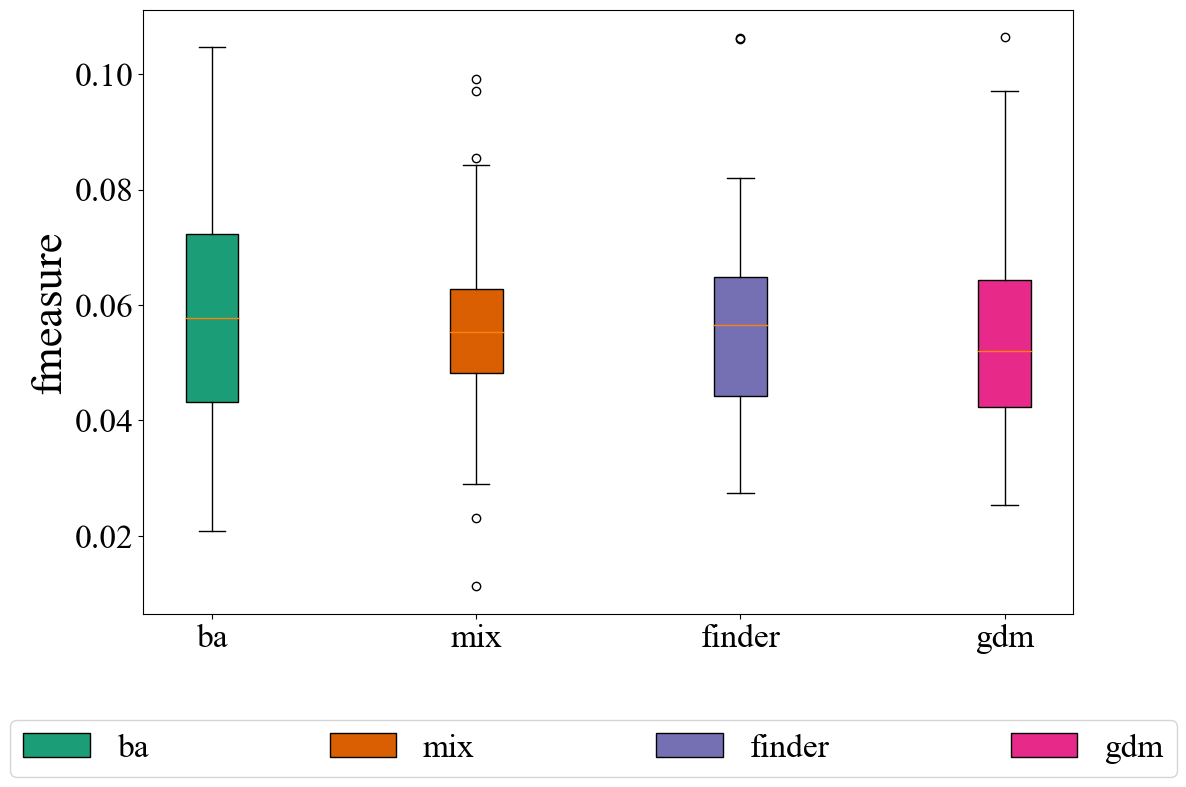

ba=>  mix=>  finder=>  gdm=>  

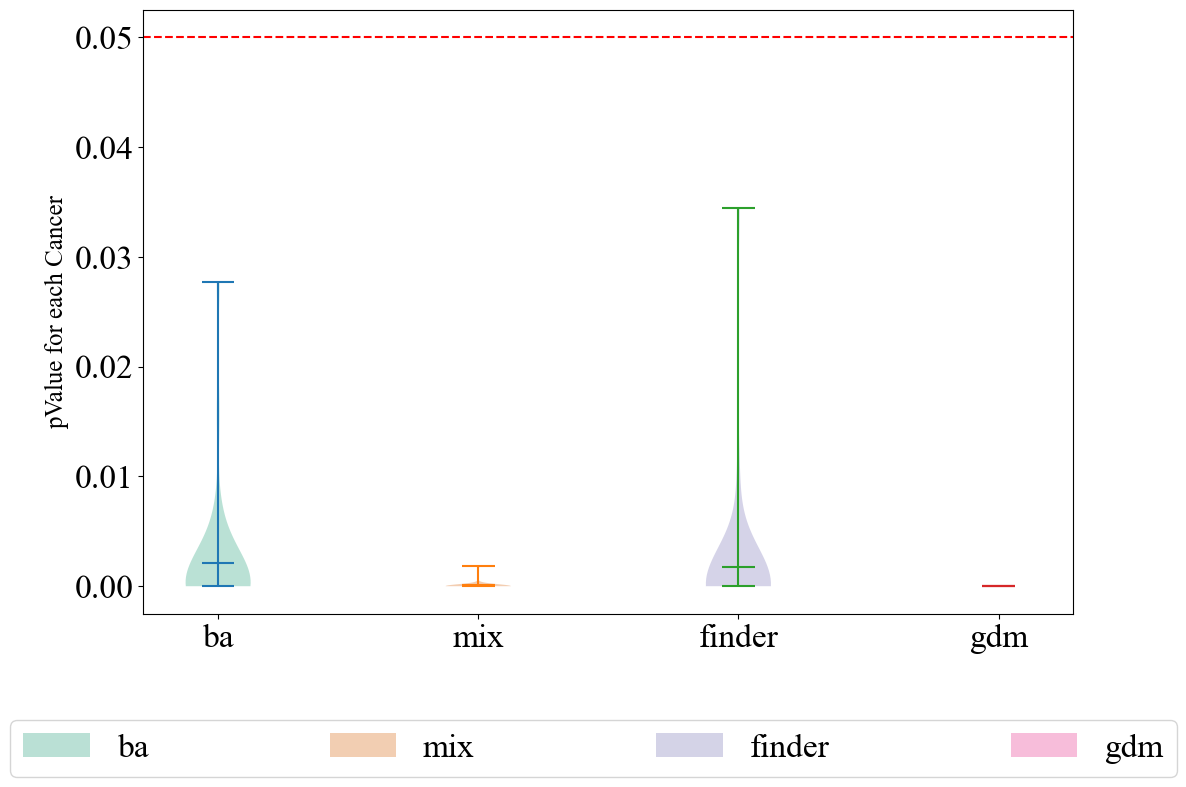

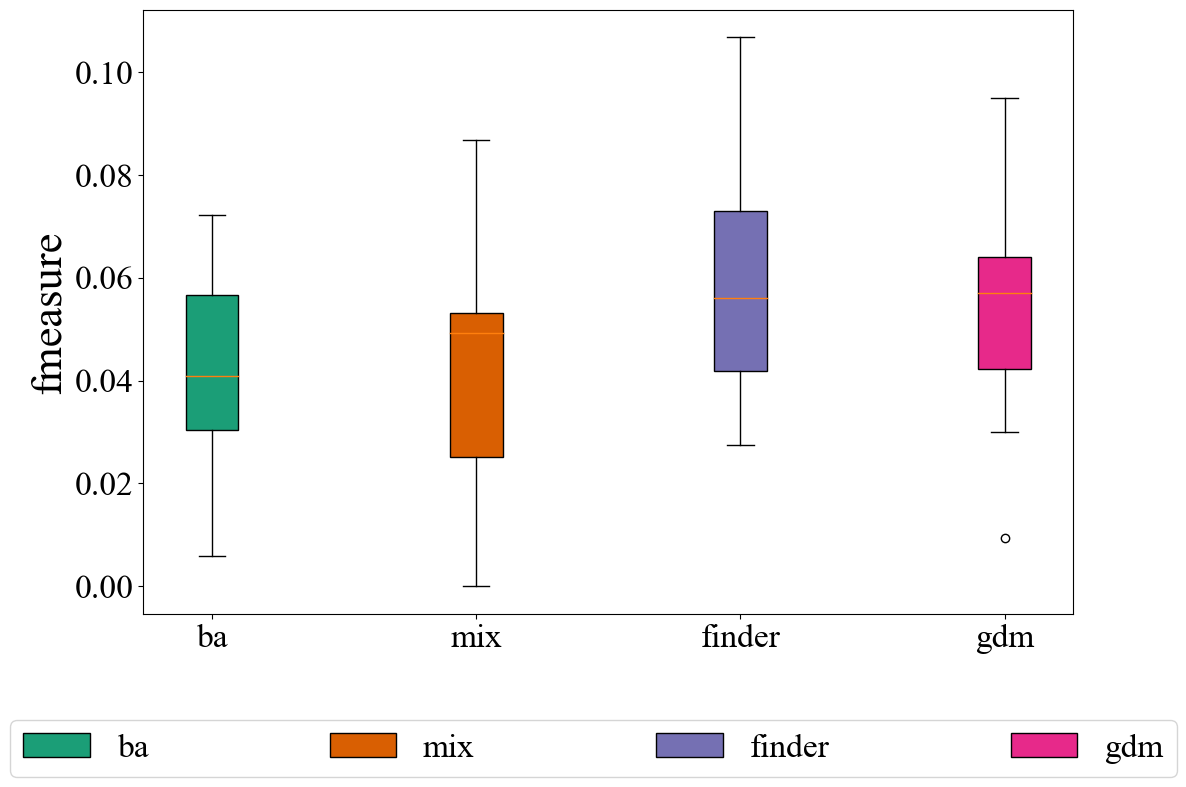

ba=>  mix=>  finder=>  gdm=>  

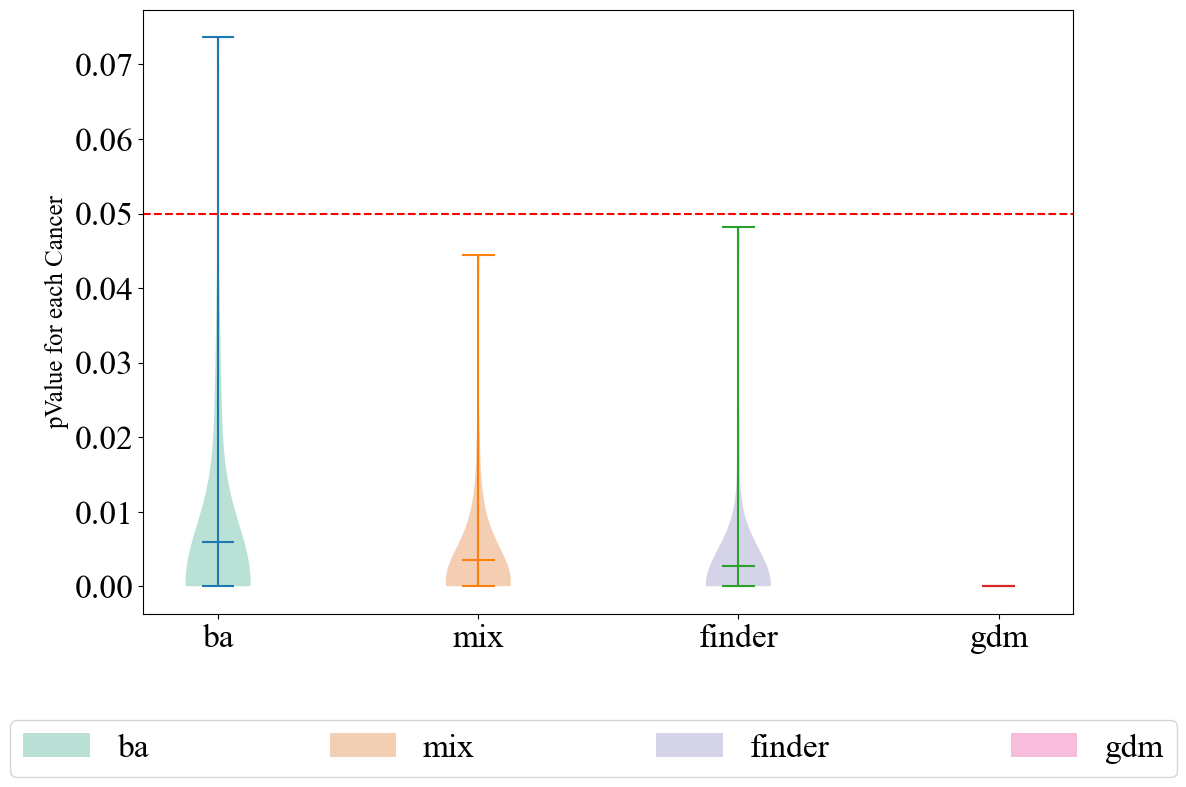

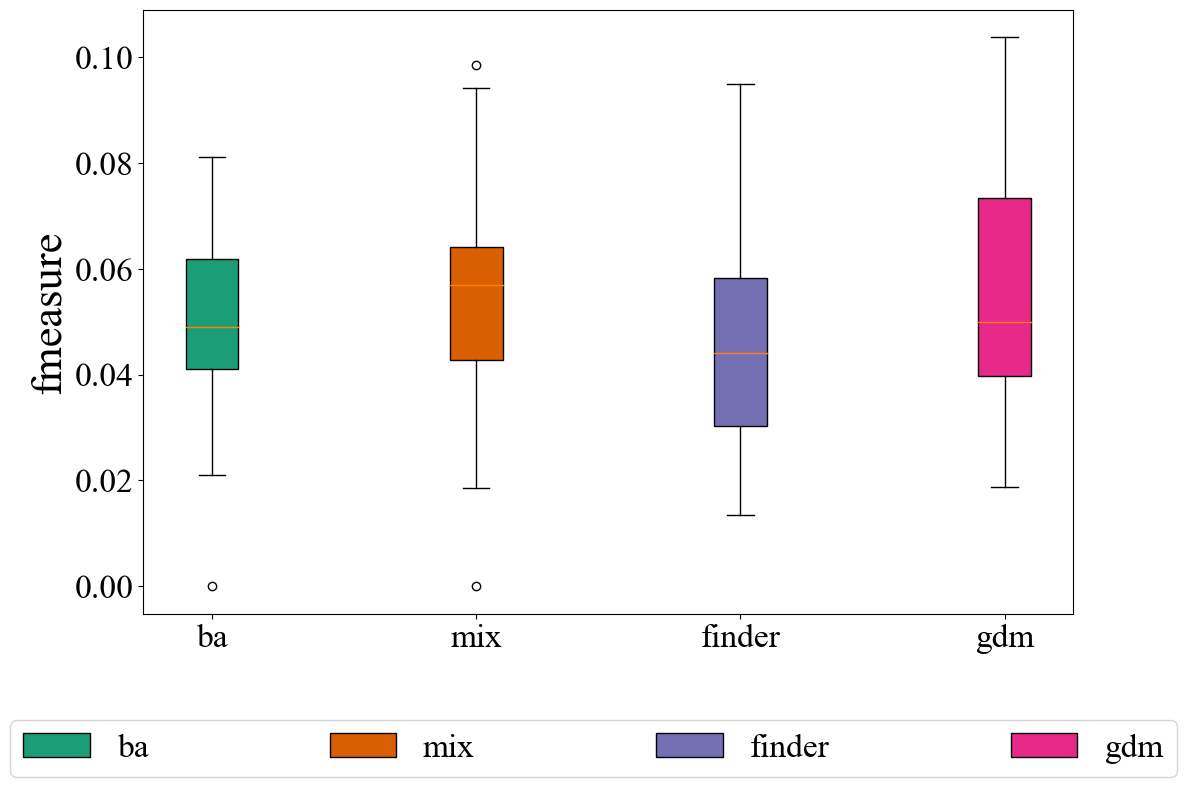

ba=>  mix=>  finder=>  gdm=>  

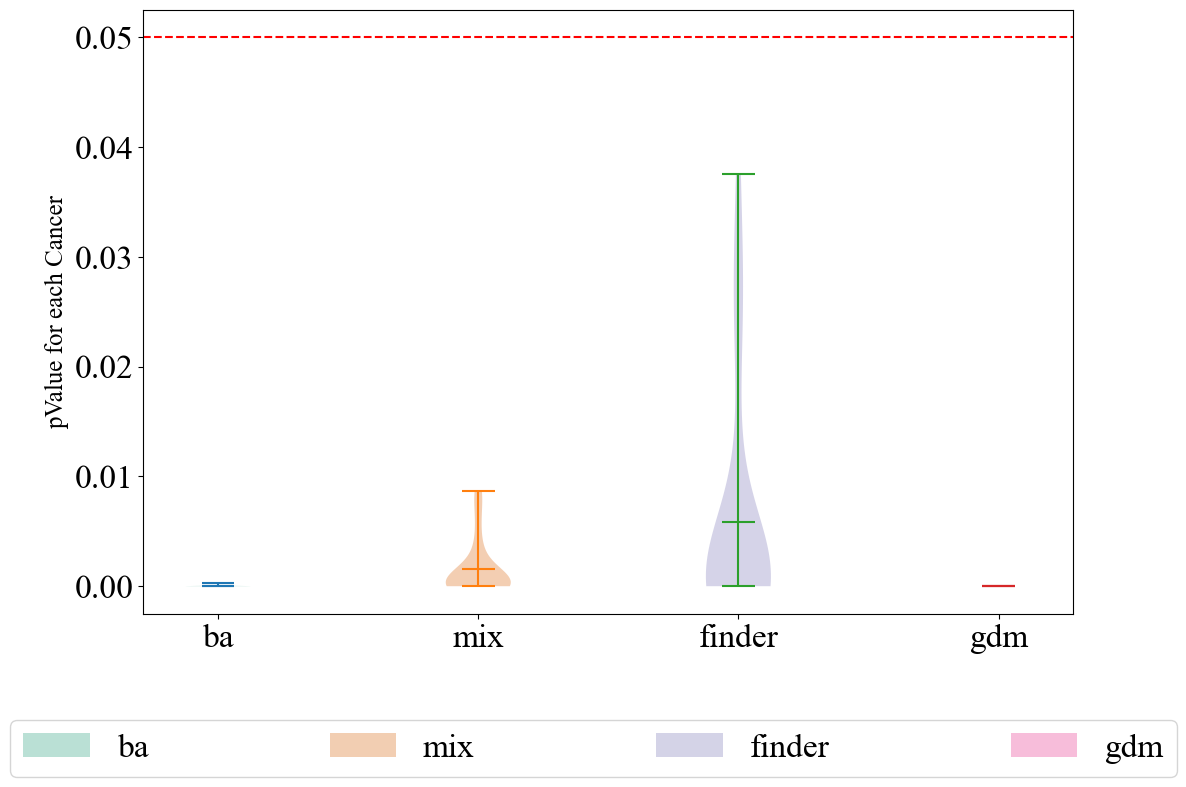

In [18]:
import math
import matplotlib
def boxplot_appeal(bp):
    for flier in bp['fliers']:    # outliers
        flier.set_markersize(4)
        flier.set_marker('o')
    for box in bp['boxes']:     # box bodys
        '''box.set_facecolor('green')
        box.set_edgecolor('black')'''
        box.set_linewidth(1)
    for whisker in bp['whiskers']:   # whisker line
        whisker.set_linewidth(2)
    for cap in bp['caps']:     # cap line
        cap.set_color('red')
        cap.set_linewidth(4)
    for median in bp['medians']:   # median line
        median.set_linewidth(3)
from scipy.stats import hypergeom
font = {'family':"Times New Roman",
            'weight' : 'normal',
        'size'   : 24}
matplotlib.rc('font', **font)
def compute_pValue_all(result,obj,color):
    fig, ax =plt.subplots(figsize =(12,8), dpi=100)
    model_list = model_list = ['ba', 'mix', 'finder','gdm'] #list(result["STAD_1"][obj].keys())
    lists = ["STAD","KIRP","KICH"]
    n_models = len(model_list)
    shift = 1 / (n_models + 1)
    handles = []
    model_pValue = {model:[] for model in model_list}
    for color_code, model in enumerate(model_list):
        print(model, end ="=>  ")
        
        for cancer_patient in (result.keys()):
            cancer = cancer_patient.split("_")[0] 
            if not(cancer in lists):
                continue
            GRAPH, map = input_graph("./Dataset/GeneNetwork/Pair-SSN/",cancer_patient)
            N = GRAPH.vcount()
            actions = result[cancer_patient][obj][model]["actions"]
            value = result[cancer_patient][obj][model]["obj"]
            #actions = actions[0:int(0.1*N)]
            # M = (N)The number of genes in the background gene interaction network = M = 11648  from Gene Interaction Network with (583 genes)
            # n = (K)The number of cancer gene in the  gold standard cancer gene list = 743
            # k = (k)number of predicted personalized gene network
            # N = (n)the number of predicted personalized driver gnes
            if model in ["ba",'mix',"gdm","finder"]:
                f1, count, totalGene = get_action(GRAPH,actions,value,cancer_patient,indexOn=True)
            else:
                f1, count, totalGene = get_action(GRAPH,actions,value,cancer_patient,indexOn=False)
            k = count#result[cancer_patient][obj][model]["count"]
            n = 743
            M = 11648
            N = len(actions)
            p = hypergeom.pmf(k,M, n, N)
            model_pValue[model].append(p)
    for position,key in enumerate(model_pValue):
        #bp = ax.boxplot(pValue[key],  positions=[-5+position*20+color_code*2], widths=2,patch_artist=True, boxprops=dict(facecolor=color[color_code]))
        bp = ax.violinplot(model_pValue[key],  positions=[position*20],showmeans=True, widths=5)
        for pc in bp["bodies"]:
            pc.set_facecolor(color[position])
        #boxplot_appeal(bp)
        handles.append(bp["bodies"][0])
        ax.set_xticks(np.arange(0, len(model_pValue))*20)
        ax.set_xticklabels(model_pValue.keys())
    x = (color_code + 1) * shift - shift / 2
    #ax.set_title(obj+ ": The p-value of personalized driver genes enriched in CCG and NCG genes", fontsize=14,fontweight="bold")
    plt.ylabel("pValue for each Cancer", fontsize=18)
    fig.legend(handles, model_list,loc = "lower left", bbox_to_anchor=(0, -0.1,1 ,1 ),  fontsize=24, mode = "expand", ncol = len(model_list))
    #if obj != "MaxNum":
    plt.axhline(y = 0.05, color = 'r', linestyle = '--')
    plt.savefig("./Figure/Compiled/HDA/Gene/Gene_pValue_"+obj+".png",bbox_inches='tight', pad_inches=0.1)
    plt.show()
def compute_fmeasure_all(result,obj, color):
    fig, ax =plt.subplots(figsize =(12,8), dpi=100)
    model_list = ['ba', 'mix', 'finder','gdm'] #list(result["STAD_1"][obj].keys()) 
    lists = ["STAD","KIRP","KICH"]
    n_models = len(model_list)
    shift = 1 / (n_models + 1)
    handles = []
    model_fmeasure = {model:[] for model in model_list}
    for color_code, model in enumerate(model_list):
        for cancer_patient in (result.keys()):
            cancer = cancer_patient.split("_")[0] 
            if not(cancer in lists):
                continue
            GRAPH, map = input_graph("./Dataset/GeneNetwork/Pair-SSN/",cancer_patient)
            N = GRAPH.vcount()
            actions = result[cancer_patient][obj][model]["actions"]
            value = result[cancer_patient][obj][model]["obj"]
            #actions = actions[0:int(0.1*N)]
            # M = (N)The number of genes in the background gene interaction network = M = 11648  from Gene Interaction Network with (583 genes)
            # n = (K)The number of cancer gene in the  gold standard cancer gene list = 743
            # k = (k)number of predicted personalized gene network
            # N = (n)the number of predicted personalized driver gnes
            if model in ["ba","mix","gdm","finder"]:
                f1, count, totalGene = get_action(GRAPH,actions,value,cancer_patient,indexOn=True)
            else:
                f1, count, totalGene = get_action(GRAPH,actions,value,cancer_patient,indexOn=False)
            model_fmeasure[model].append(f1)
    for position,key in enumerate(model_fmeasure):
        #bp = ax.violinplot(model_fmeasure[key],  positions=[position*20],showmeans=True, widths=5)
        bp = ax.boxplot(model_fmeasure[key],  positions=[position*20], widths=4,patch_artist=True, boxprops=dict(facecolor=color[position]))
        '''for pc in bp["bodies"]:
            pc.set_facecolor(color[position])'''
        #boxplot_appeal(bp)
        #handles.append(bp["bodies"][0])
        handles.append(bp["boxes"][0])
        ax.set_xticks(np.arange(0, len(model_fmeasure))*20)
        ax.set_xticklabels(model_fmeasure.keys())
        x = (color_code + 1) * shift - shift / 2
    #ax.set_title(obj+ ": The fmeasure of personalized driver genes enriched in CCG and NCG genes", fontsize=14,fontweight="bold")
    plt.ylabel("fmeasure", fontsize=32)
    fig.legend(handles, model_list,loc = "lower left", bbox_to_anchor=(0, -0.1,1 ,1 ),  fontsize=24, mode = "expand", ncol = len(model_list))
    #plt.savefig("./Figure/Compiled/HDA/Gene/Gene_fmeasure_"+obj+".pdf",bbox_inches='tight', pad_inches=0.1)
    plt.savefig("./Figure/Compiled/HDA/Gene/Gene_fmeasure_"+obj+".png",bbox_inches='tight', pad_inches=0.1)
    plt.show()
JSON_FILE = get_from_json("./Figure/Compiled/HDA/Gene/personalized_gene_1.json")
JSON_FILE = get_from_json("./Figure/Compiled/HDA/Gene/personalized_gene.json")
color = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
obj_list = ["MinMax", "CNP", "MaxNum"]
for obj in obj_list:
    compute_fmeasure_all(JSON_FILE,obj,color)
    compute_pValue_all(JSON_FILE,obj,color)

In [21]:
import pandas as pd
def export_gene_results_to_csv(result, obj_list, save_path="./Figure/Compiled/HDA/Gene/gene_results_fmeasure_pvalues.csv"):
    model_list = ['ba', 'mix', 'finder', 'gdm']
    cancer_list = ["STAD", "KIRP", "KICH"]
    records = []

    for obj in obj_list:
        for model in model_list:
            for cancer_patient in result.keys():
                cancer = cancer_patient.split("_")[0]
                if cancer not in cancer_list:
                    continue
                try:
                    GRAPH, map = input_graph("./Dataset/GeneNetwork/Pair-SSN/", cancer_patient)
                    actions = result[cancer_patient][obj][model]["actions"]
                    value = result[cancer_patient][obj][model]["obj"]

                    # Get f1 and count
                    f1, count, totalGene = get_action(GRAPH, actions, value, cancer_patient, indexOn=True)

                    # Compute p-value
                    k = count
                    n = 743
                    M = 11648
                    N = len(actions)
                    p = hypergeom.pmf(k, M, n, N)

                    records.append({
                        "model": model,
                        "cancer_patient": cancer_patient,
                        "cancer": cancer,
                        "objective": obj,
                        "fmeasure": f1,
                        "pvalue": p,
                        "count":count,
                        "totalGene":totalGene
                    })
                except Exception as e:
                    print(f"Error processing {cancer_patient}, {model}, {obj}: {e}")
                    continue

    df = pd.DataFrame(records)
    df.to_csv(save_path, index=False)
    print(f"Saved CSV to {save_path}")
JSON_FILE = get_from_json("./Figure/Compiled/HDA/Gene/personalized_gene.json")
obj_list = ["MinMax", "CNP", "MaxNum"]

export_gene_results_to_csv(JSON_FILE, obj_list)

Saved CSV to ./Figure/Compiled/HDA/Gene/gene_results_fmeasure_pvalues.csv
